[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)

# based on Fig 2. in [Fisher 1991](https://doi.org/10.3402/tellusb.v43i5.15414)
Deuterium excess $d=\delta(D) - 8\delta( ^{18}O)$

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from matplotlib import pyplot
import numpy as np
from open_atmos_jupyter_utils import show_plot
from scipy.integrate import solve_ivp
from functools import partial

from PySDM import Formulae
from PySDM.physics import si, isotope_diffusivity_ratios
from PySDM.physics.constants import PER_MILLE, in_unit
from PySDM_examples.Jouzel_and_Merlivat_1984.thermodynamic_profiles import (
    vapour_mixing_ratio,
    ice_saturation_curve_4
)

In [3]:
formulae = Formulae(
    isotope_meteoric_water_line="Dansgaard1964",
    isotope_diffusivity_ratios="Stewart1975",
    isotope_kinetic_fractionation_factors="BolotEtAl2013",
    isotope_equilibrium_fractionation_factors="MerlivatAndNief1967+Majoube1970",
)
const = formulae.constants

## d-excess for isotope_equilibrium_fractionation_factors from Merlivat & Nief 1967 and Majoube 1970

In [4]:
def alpha_eff(T, alpha_s, diffusivity_ratio):
    a = alpha_s(T=T)
    a *= alpha_kinetic(
            alpha_equilibrium=a,
            saturation_over_ice=ice_saturation_curve_4(const,T),
            heavy_to_light_diffusivity_ratio= diffusivity_ratio
        )
    return a

In [5]:
def d_delta_dT(T, delta):
    y = yf(T=T)
    
    dT = 1 * si.K
    dy_dT = (yf(T=T+dT) - y) / dT
    res = [0,0]
    for i, iso in enumerate(isotopes):
        diffusivity_ratio = formulae.isotope_diffusivity_ratios.ratio_2H(T) if iso == '2H' else formulae.isotope_diffusivity_ratios.ratio_18O(T)
        alpha = alpha_eff(T=T, alpha_s=alpha_eq[iso], diffusivity_ratio=diffusivity_ratio)
        alpha_dT = alpha_eff(T=T+dT, alpha_s=alpha_eq[iso], diffusivity_ratio=diffusivity_ratio)
        d_alpha_dT = (alpha_dT - alpha) / dT
        res[i] = (
            (1 + delta[i])
            * (alpha * (alpha - 1) * dy_dT + y * d_alpha_dT)
            / alpha
            / (y + alpha * y_e)
        )
    return res 


In [6]:
y_e = 0
delta_18O_0 = -15 * PER_MILLE
delta_2H_0 = const.CRAIG_1961_SLOPE_COEFF * delta_18O_0
temperature = np.linspace(260, 230, 20)
yf = partial(vapour_mixing_ratio, formulae=formulae)

In [7]:
isotopes = ('2H', '18O')
alpha_kinetic = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic
alpha_eq = {}
for iso in isotopes:
    alpha_eq[iso] = getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_i_{iso}')
res = solve_ivp(
    fun=d_delta_dT,
    t_span=(temperature[0], temperature[-1]),
    y0=[delta_2H_0, delta_18O_0],
    t_eval=temperature,
)
assert res.success, res.message
delta_2H, delta_18O = res.y
d_excess = formulae.isotope_meteoric_water_line.excess_d(
            delta_2H=delta_2H,
            delta_18O=delta_18O,
        )

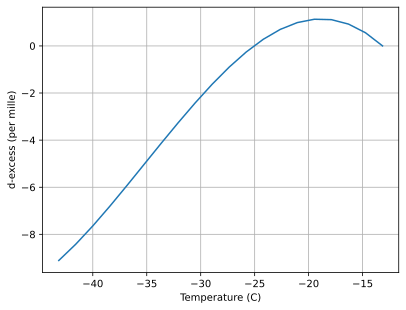

In [8]:
pyplot.plot(
    formulae.trivia.K2C(temperature[::-1]),
    in_unit(d_excess,PER_MILLE)[::-1]
)
pyplot.gca().set(
    xlabel = 'Temperature (C)',
    ylabel = 'd-excess (per mille)'
)
pyplot.grid()
show_plot('fig_2')